In [1]:
import os
import sys
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import vqr
from vqr import VectorQuantileEstimator, VectorQuantileRegressor

import pyhrv
from pyhrv.wfdb.rri import ecgrr
from pyhrv.rri.processing import filtrr

plt.rcParams['font.size'] = 14

In [2]:
from dataclasses import dataclass
from typing import Iterator, Sequence

DATASET_BASE_PATH = Path('/Users/aviv/dev/datasets/physionet')

@dataclass
class Dataset:
    name: str
    ann_ext: str
    path: Path = None
    
    def __post_init__(self):
        if not self.path:
            self.path = DATASET_BASE_PATH.joinpath(self.name)
        
        self._records = tuple(
            self.path.joinpath(dat_path.stem) for dat_path in self.path.glob("*.dat")
        )
         
    @property
    def records(self) -> Sequence[Path]:
        return self._records
    
    def __len__(self):
        return len(self._records)

DATASETS = {
    ds.name: ds for ds in [
        Dataset(name="nsrdb", ann_ext="atr"),
        Dataset(name="chfdb", ann_ext="ecg"),
        Dataset(name="afdb", ann_ext="qrs"),
    ]
}

nsrdb = DATASETS['nsrdb']
chfdb = DATASETS['chfdb']
afdb = DATASETS['afdb']


In [3]:
DATASETS['nsrdb']

Dataset(name='nsrdb', ann_ext='atr', path=PosixPath('/Users/aviv/dev/datasets/physionet/nsrdb'))

In [4]:
def plot_datasets_rri(
    datasets: Sequence[Dataset],
    n_recs: int = 10,
    random: bool = False,
    from_time: str = None,
    to_time: str = None,
):
    
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(10*n_datasets, 6))
    if n_datasets == 1:
        axes = [axes]
    
    for i_ds, ds in enumerate(datasets):
        ax = axes[i_ds]
        
        if random:
            idx = np.random.permutation(len(ds))[:n_recs]
            records = list(np.array(ds.records)[idx])
        else:
            records = ds.records[:n_recs]
        
        for j_rec, rec_path in enumerate(records):
            trr, xrr = ecgrr(
                rec_path=str(rec_path),
                ann_ext=ds.ann_ext,
                from_time=from_time,
                to_time=to_time,
            )
            trr, xrr = filtrr(trr, xrr, enable_range=True, enable_moving_average=False)
            ax.plot(trr, xrr, label=rec_path.name)
            
        ax.set_ylim([0.2, 2.0])
        ax.legend()
        ax.grid('on')
        ax.set_title(ds.name)
            

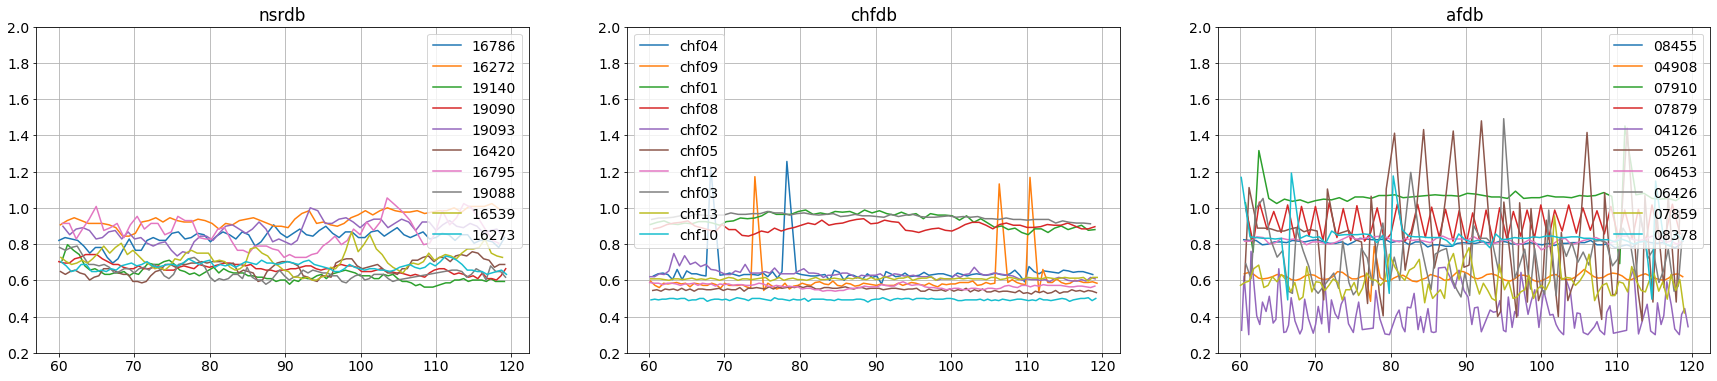

In [5]:
plot_datasets_rri(datasets=[nsrdb, chfdb, afdb], n_recs=10, random=True, from_time="0:01:00", to_time="0:02:00")

In [6]:
from __future__ import division
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast

def chunk_data(data, window_size, overlap_size=0, flatten_inside_window=True):
    assert data.ndim == 1 or data.ndim == 2
    if data.ndim == 1:
        data = data.reshape((-1,1))

    # get the number of overlapping windows that fit into the data
    num_windows = (data.shape[0] - window_size) // (window_size - overlap_size) + 1
    overhang = data.shape[0] - (num_windows*window_size - (num_windows-1)*overlap_size)

    # if there's overhang, need an extra window and a zero pad on the data
    # (numpy 1.7 has a nice pad function I'm not using here)
    if overhang != 0:
        num_windows += 1
        newdata = np.zeros((num_windows*window_size - (num_windows-1)*overlap_size,data.shape[1]))
        newdata[:data.shape[0]] = data
        data = newdata

    sz = data.dtype.itemsize
    ret = ast(
            data,
            shape=(num_windows,window_size*data.shape[1]),
            strides=((window_size-overlap_size)*data.shape[1]*sz,sz)
            )

    if flatten_inside_window:
        return ret
    else:
        return ret.reshape((num_windows,-1,data.shape[1]))

nsrdb/16273
chfdb/chf07
afdb/08455


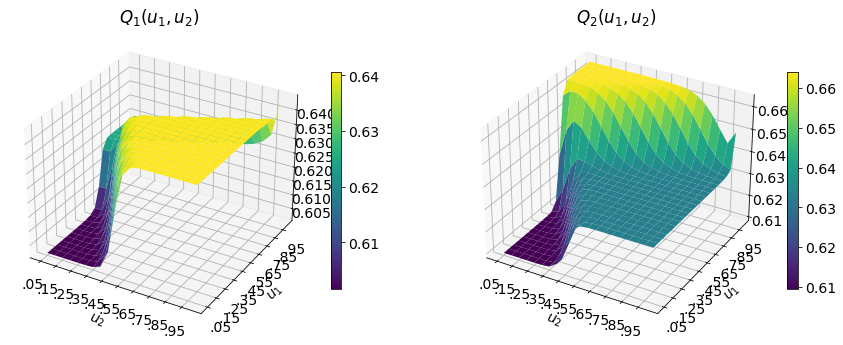

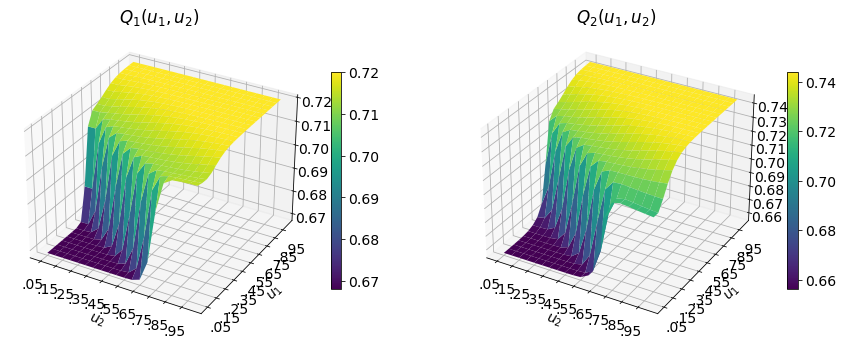

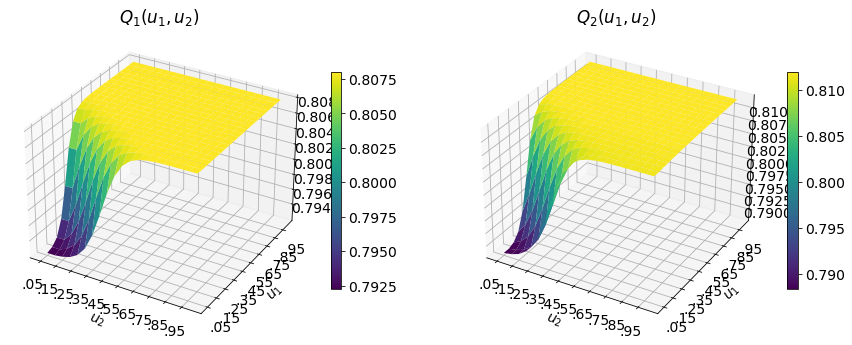

In [7]:
rec_idx = 10
from_time="0:01:00"
to_time="0:05:00"

d = 2
T = 20

for i_ds, ds in enumerate(DATASETS.values()):
    rec_path = ds.records[rec_idx]
    rec_name = f"{ds.name}/{rec_path.name}"
    print(rec_name)
    trr, xrr = ecgrr(rec_path, ds.ann_ext, from_time=from_time, to_time=to_time)
    trr, xrr = filtrr(trr, xrr, enable_range=True, enable_moving_average=False)
    Y = chunk_data(xrr, window_size=d, overlap_size=d-1)
    vqe = VectorQuantileEstimator(n_levels=T, solver_opts={'verbose': False})
    vqe.fit(Y)
    vqe.plot_quantiles(figsize=(15, 20), surf_2d=True);

In [8]:
from scipy.spatial import ConvexHull

def plot_coverage_2d(
    Q1,
    Q2,
    Y_valid=None,
    Y_train=None,
    alpha=0.1,
    ax=None,
    title=None,
    xylim=None,
    xlabel=None,
    ylabel=None,
    contour_color="k",
    contour_label: str=None,
):
    T = Q1.shape[0]
    assert Q1.shape == Q2.shape == (T, T)
    assert 0.0 < alpha < 0.5
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    else:
        fig, ax = None, ax
        
    i_lo = int(np.floor(T * alpha))
    i_hi = int(np.ceil(T * (1-alpha)))
    
    Q_surface = np.array( # (N, 2)
        [
            [*Q1[i_lo:i_hi, i_hi], *Q1[i_lo, i_lo:i_hi], *Q1[i_lo:i_hi, i_lo], *Q1[i_hi, i_lo:i_hi]],
            [*Q2[i_lo:i_hi, i_hi], *Q2[i_lo, i_lo:i_hi], *Q2[i_lo:i_hi, i_lo], *Q2[i_hi, i_lo: i_hi]]
        ]
    ).T
        
    surf_kws = dict(alpha=.5, color=contour_color, s=200, marker='v')
    ax.scatter(*Q_surface.T, **surf_kws)
        
    # Plot convex hull
    hull = ConvexHull(Q_surface)
    for i, simplex in enumerate(hull.simplices):
        label = None
        if i==len(hull.simplices)-1:
            label = contour_label or rf"Quantile Contour ($\alpha$={alpha})"
        ax.plot(Q_surface[simplex, 0], Q_surface[simplex, 1], color=contour_color, label=label)
        
    def point_in_hull(point, hull, tolerance=1e-12):
        return all((np.dot(eq[:-1], point) + eq[-1] <= tolerance) for eq in hull.equations)
        
    # Plot training data
    if Y_train is not None:
        ax.scatter(*Y_train.T, color="k", alpha=0.3, label="training data")
        
    coverage = None
    # Plot validation data
    if Y_valid is not None:
        is_in_hull = np.array([point_in_hull(p, hull) for p in Y_valid])
        coverage = np.mean(is_in_hull).item()
        ax.scatter(*Y_valid[is_in_hull,:].T, marker="x", color="g", label="validation")
        ax.scatter(*Y_valid[~is_in_hull,:].T, marker="d", color="m", label=f"validation outliers (cov={coverage*100:.2f})")
    
    ax.set_xlim(xylim); ax.set_ylim(xylim)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel);
    ax.set_title(title)
    ax.legend()
    return fig, ax, coverage

## Coverage

nsrdb/16420: Y_train.shape=(558, 2), Y_valid.shape=(89, 2)
chfdb/chf03: Y_train.shape=(383, 2), Y_valid.shape=(63, 2)
afdb/08378: Y_train.shape=(441, 2), Y_valid.shape=(68, 2)
nsrdb/16786: Y_train.shape=(445, 2), Y_valid.shape=(70, 2)
chfdb/chf15: Y_train.shape=(574, 2), Y_valid.shape=(92, 2)
afdb/06426: Y_train.shape=(483, 2), Y_valid.shape=(74, 2)
nsrdb/16483: Y_train.shape=(541, 2), Y_valid.shape=(83, 2)
chfdb/chf04: Y_train.shape=(560, 2), Y_valid.shape=(91, 2)
afdb/04746: Y_train.shape=(391, 2), Y_valid.shape=(61, 2)
nsrdb/16265: Y_train.shape=(602, 2), Y_valid.shape=(110, 2)
chfdb/chf11: Y_train.shape=(689, 2), Y_valid.shape=(107, 2)
afdb/06453: Y_train.shape=(427, 2), Y_valid.shape=(69, 2)
nsrdb/16273: Y_train.shape=(545, 2), Y_valid.shape=(81, 2)
chfdb/chf07: Y_train.shape=(499, 2), Y_valid.shape=(85, 2)
afdb/08455: Y_train.shape=(448, 2), Y_valid.shape=(74, 2)


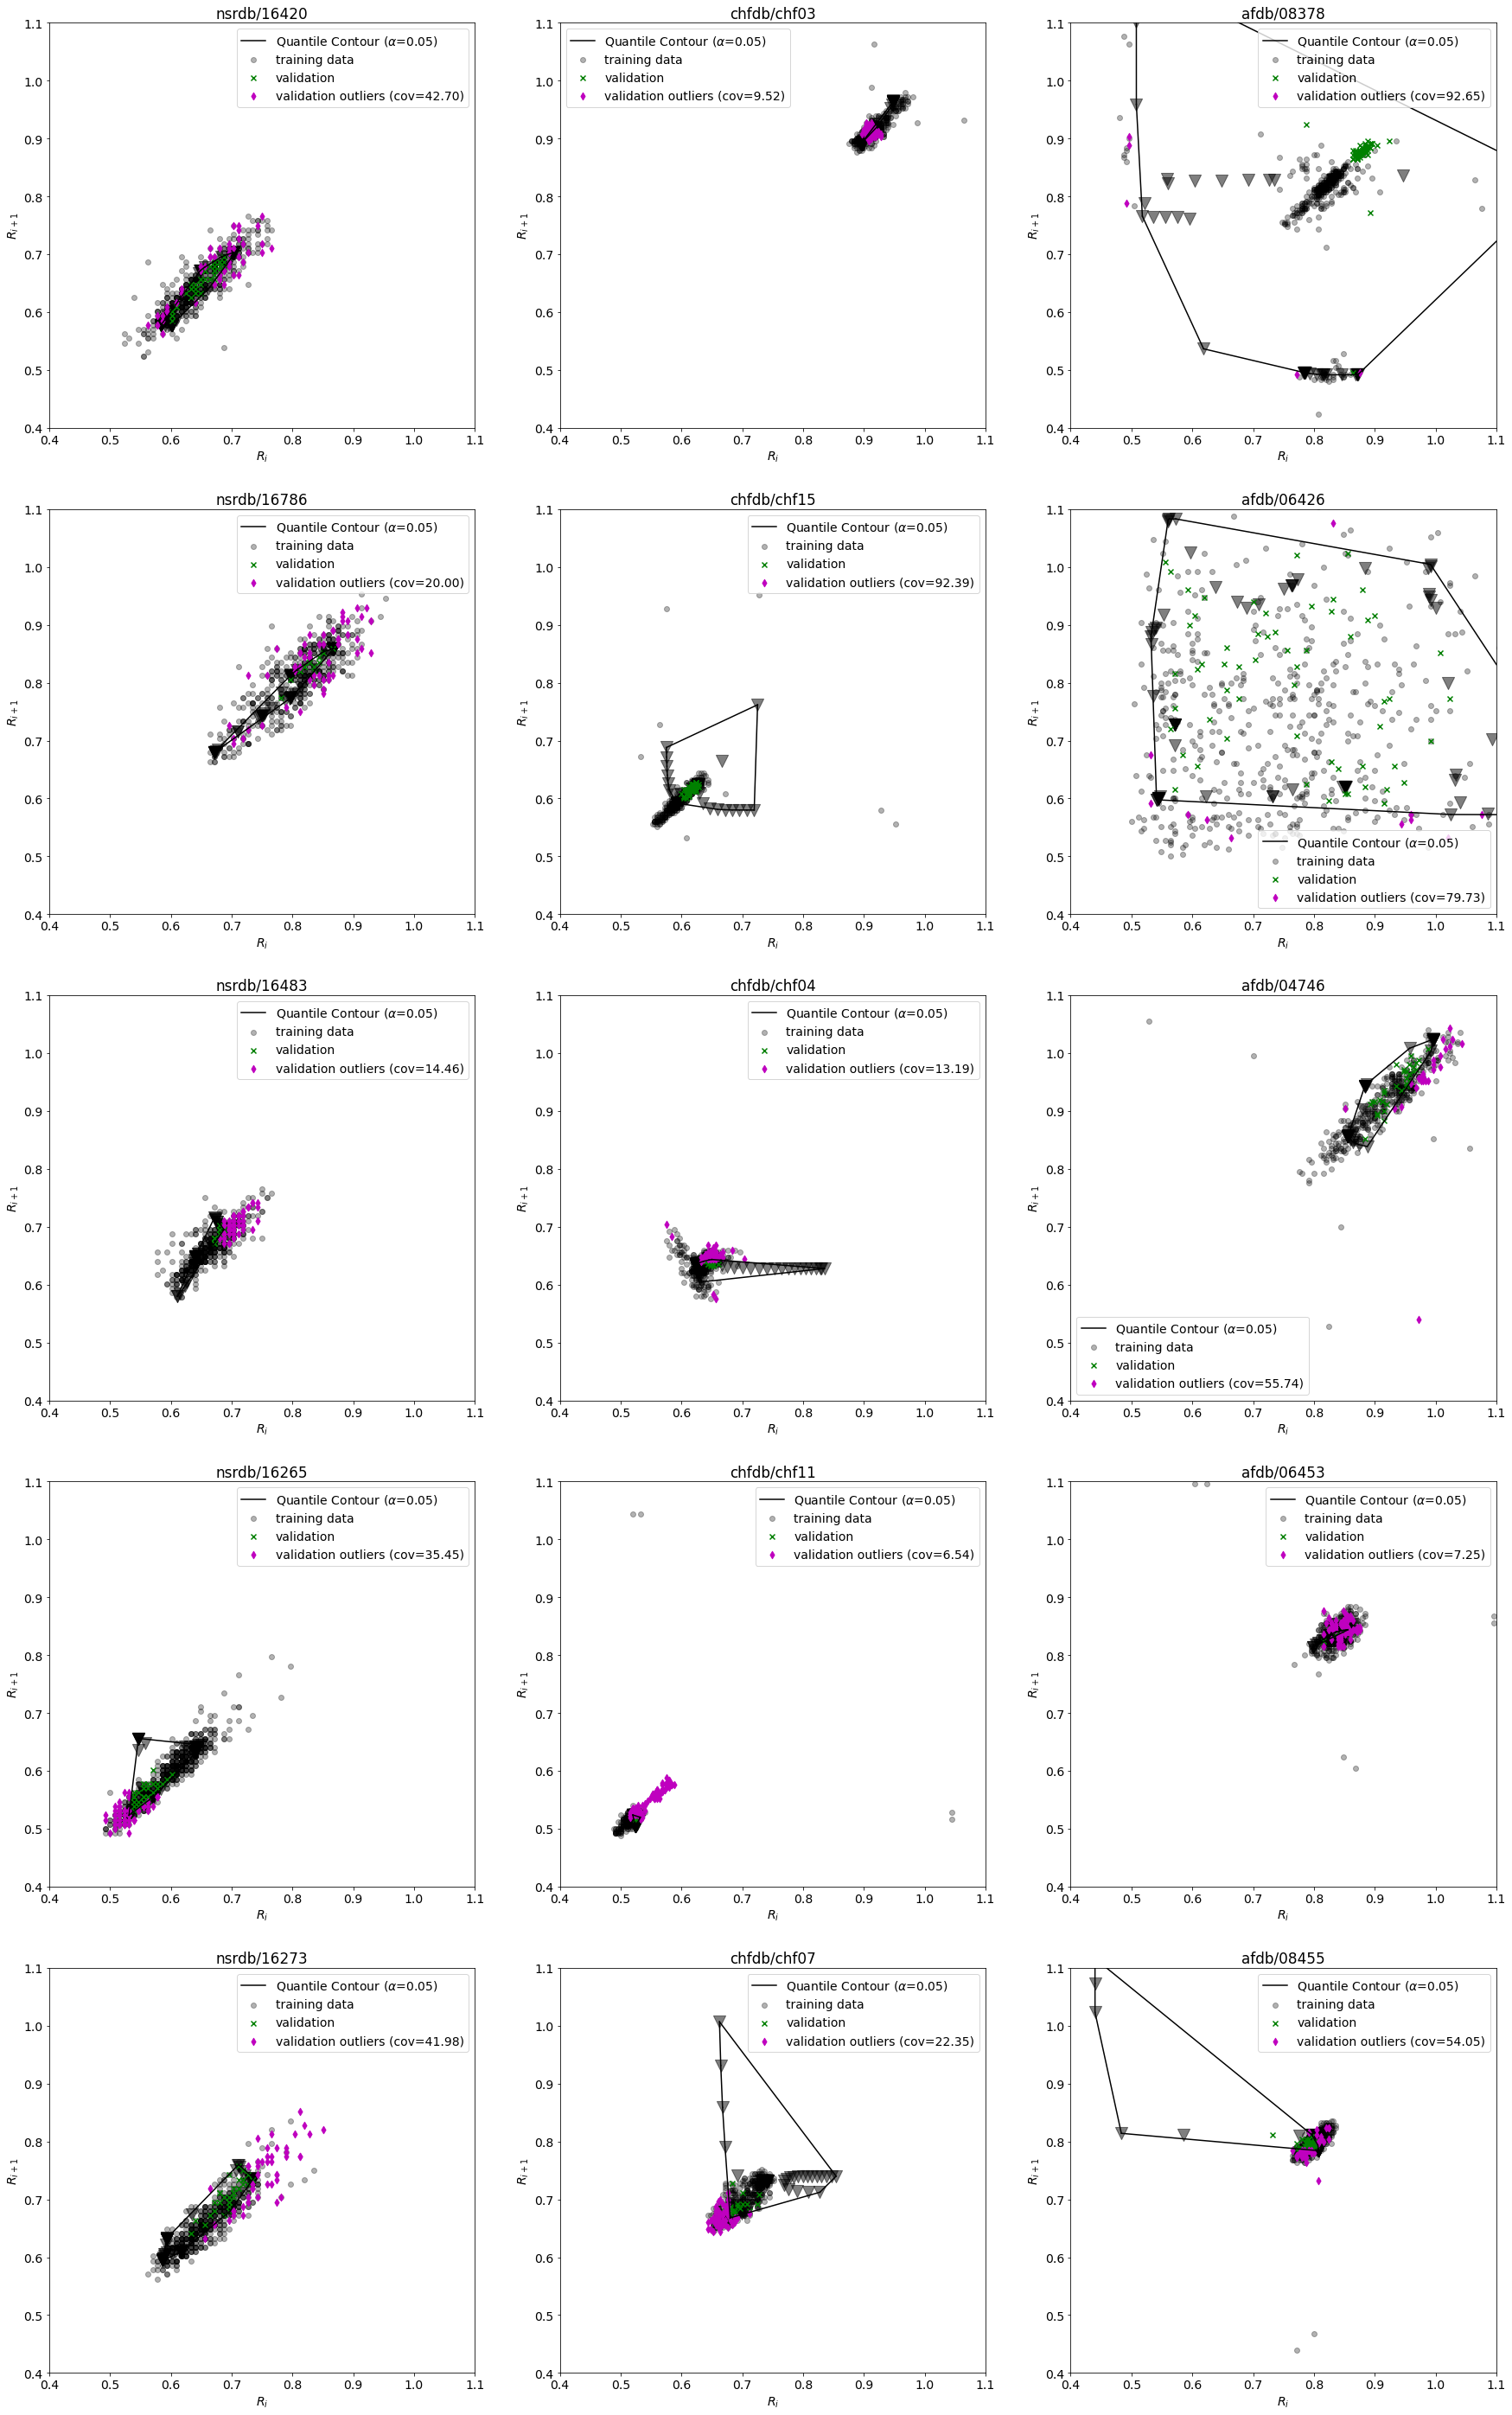

In [9]:
rec_idxs = [1, 3, 5, 7, 10]

train_start_h = 1
train_duration_h = 6
valid_start_h = train_start_h + train_duration_h + 0
valid_duration_h = 1

train_from_time=f"0:{train_start_h:02d}:00"
train_to_time=f"0:{train_start_h+train_duration_h:02d}:00"
valid_from_time=f"0:{valid_start_h:02d}:00"
valid_to_time=f"0:{valid_start_h+valid_duration_h:02d}:00"

fig_cov, ax_cov = plt.subplots(len(rec_idxs), len(DATASETS), figsize=(10*len(DATASETS), 10*len(rec_idxs)))
ax_cov = np.reshape(ax_cov, (len(rec_idxs), len(DATASETS)))

for i_rec, rec_idx in enumerate(rec_idxs):
    for i_ds, ds in enumerate(DATASETS.values()):
        rec_path = ds.records[rec_idx]
        rec_name = f"{ds.name}/{rec_path.name}"

        trr, xrr = ecgrr(rec_path, ds.ann_ext, from_time=train_from_time, to_time=train_to_time)
        trr, xrr = filtrr(trr, xrr, enable_range=True, enable_moving_average=False)
        Y_train = chunk_data(xrr, window_size=d, overlap_size=d-1)
        
        trr, xrr = ecgrr(rec_path, ds.ann_ext, from_time=valid_from_time, to_time=valid_to_time)
        trr, xrr = filtrr(trr, xrr, enable_range=True, enable_moving_average=False)
        Y_valid = chunk_data(xrr, window_size=d, overlap_size=d-1)

        print(f"{rec_name}: {Y_train.shape=}, {Y_valid.shape=}")

        vqe = VectorQuantileEstimator(n_levels=T, solver_opts={'verbose': False})
        vqe.fit(Y_train)
        Q1, Q2 = vqe.vector_quantiles()
        plot_coverage_2d(Q1, Q2, Y_valid, Y_train, alpha=0.05, title=rec_name, ax=ax_cov[i_rec,i_ds], xylim=[0.4, 1.1], xlabel="$R_i$", ylabel="$R_{i+1}$");

## Multi-scale

afdb/08378: Y_train.shape=(441, 2), Y_train_coarse.shape=(441, 2), scale=1
afdb/08378: Y_train.shape=(441, 2), Y_train_coarse.shape=(437, 2), scale=5
afdb/08378: Y_train.shape=(441, 2), Y_train_coarse.shape=(433, 2), scale=9
afdb/08378: Y_train.shape=(441, 2), Y_train_coarse.shape=(429, 2), scale=13
afdb/06426: Y_train.shape=(483, 2), Y_train_coarse.shape=(483, 2), scale=1
afdb/06426: Y_train.shape=(483, 2), Y_train_coarse.shape=(479, 2), scale=5
afdb/06426: Y_train.shape=(483, 2), Y_train_coarse.shape=(475, 2), scale=9
afdb/06426: Y_train.shape=(483, 2), Y_train_coarse.shape=(471, 2), scale=13
afdb/04746: Y_train.shape=(391, 2), Y_train_coarse.shape=(391, 2), scale=1
afdb/04746: Y_train.shape=(391, 2), Y_train_coarse.shape=(387, 2), scale=5
afdb/04746: Y_train.shape=(391, 2), Y_train_coarse.shape=(383, 2), scale=9
afdb/04746: Y_train.shape=(391, 2), Y_train_coarse.shape=(379, 2), scale=13


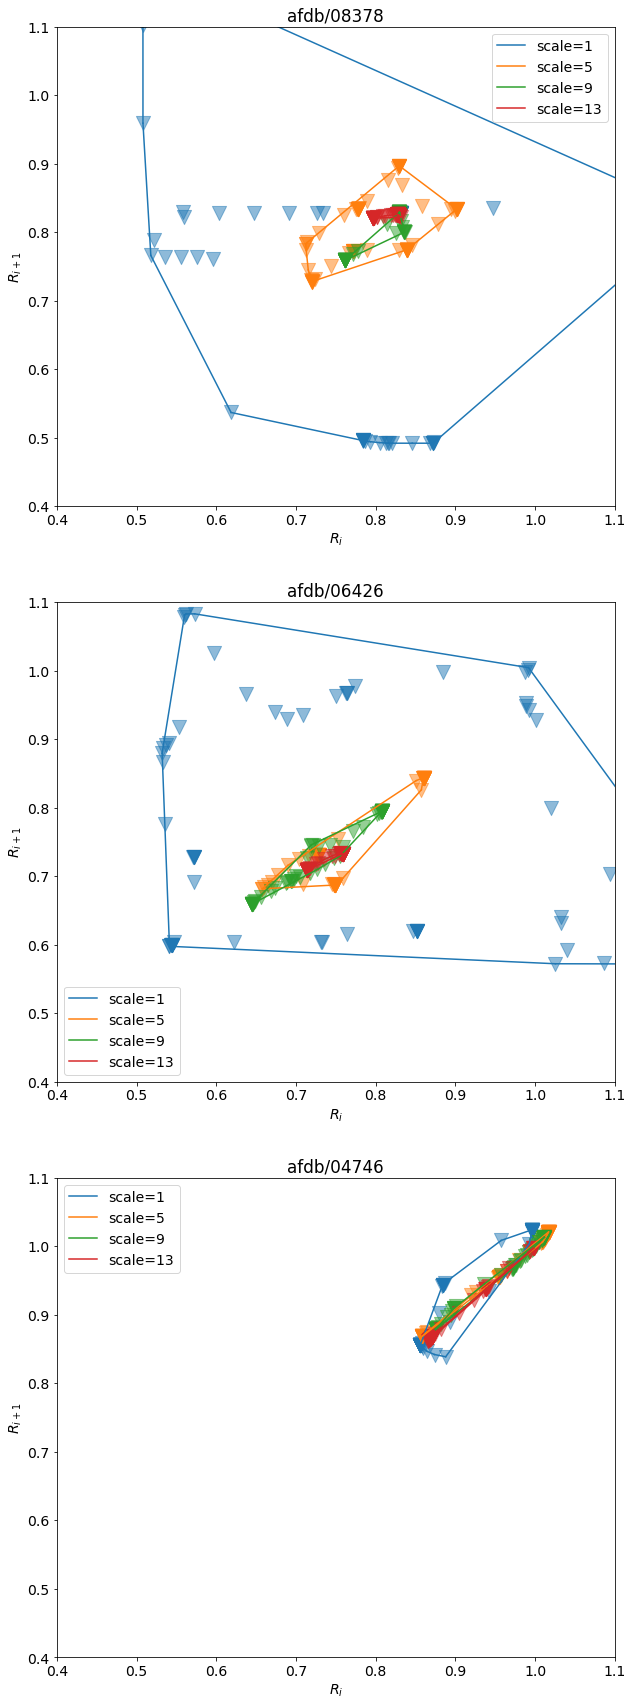

In [10]:
rec_idxs = [1, 3, 5]
scales = [1, 5, 9, 13]
ds = afdb

fig_scales, ax_scales = plt.subplots(len(rec_idxs), 1, figsize=(10*1, 10*len(rec_idxs)))
ax_scales = np.reshape(ax_scales, (len(rec_idxs), 1))

for i_rec, rec_idx in enumerate(rec_idxs):

    rec_path = ds.records[rec_idx]
    rec_name = f"{ds.name}/{rec_path.name}"

    trr, xrr = ecgrr(rec_path, ds.ann_ext, from_time=train_from_time, to_time=train_to_time)
    trr, xrr = filtrr(trr, xrr, enable_range=True, enable_moving_average=False)
    Y_train = chunk_data(xrr, window_size=d, overlap_size=d-1)
    
    for j_scale, scale in enumerate(scales):
        
        Y_train_coarse = np.concatenate([
                np.convolve(Y_train[:, j], np.ones(scale)/scale, mode="valid").reshape(-1, 1)
                for j in range(d)
            ],
            axis=1
        )
        
        print(f"{rec_name}: {Y_train.shape=}, {Y_train_coarse.shape=}, {scale=}")

        vqe = VectorQuantileEstimator(n_levels=T, solver_opts={'verbose': False})
        vqe.fit(Y_train_coarse)
        Q1, Q2 = vqe.vector_quantiles()
        
        plot_coverage_2d(
            Q1,
            Q2,
            alpha=0.05,
            title=rec_name,
            ax=ax_scales[i_rec, 0],
            xylim=[0.4, 1.1],
            xlabel="$R_i$",
            ylabel="$R_{i+1}$",
            contour_color=f"C{j_scale}",
            contour_label=f"{scale=}"
        );

## Conditional

In [11]:
from sklearn.model_selection import train_test_split

nsrdb/16420 (N_train=142, k=16)
chfdb/chf03 (N_train=96, k=11)
afdb/08378 (N_train=110, k=13)
nsrdb/16786 (N_train=113, k=13)
chfdb/chf15 (N_train=147, k=17)
afdb/06426 (N_train=123, k=14)
nsrdb/16483 (N_train=139, k=16)
chfdb/chf04 (N_train=143, k=16)
afdb/04746 (N_train=99, k=12)
nsrdb/16265 (N_train=153, k=17)
chfdb/chf11 (N_train=132, k=20)
afdb/06453 (N_train=108, k=12)
nsrdb/16273 (N_train=140, k=16)
chfdb/chf07 (N_train=126, k=14)
afdb/08455 (N_train=113, k=13)


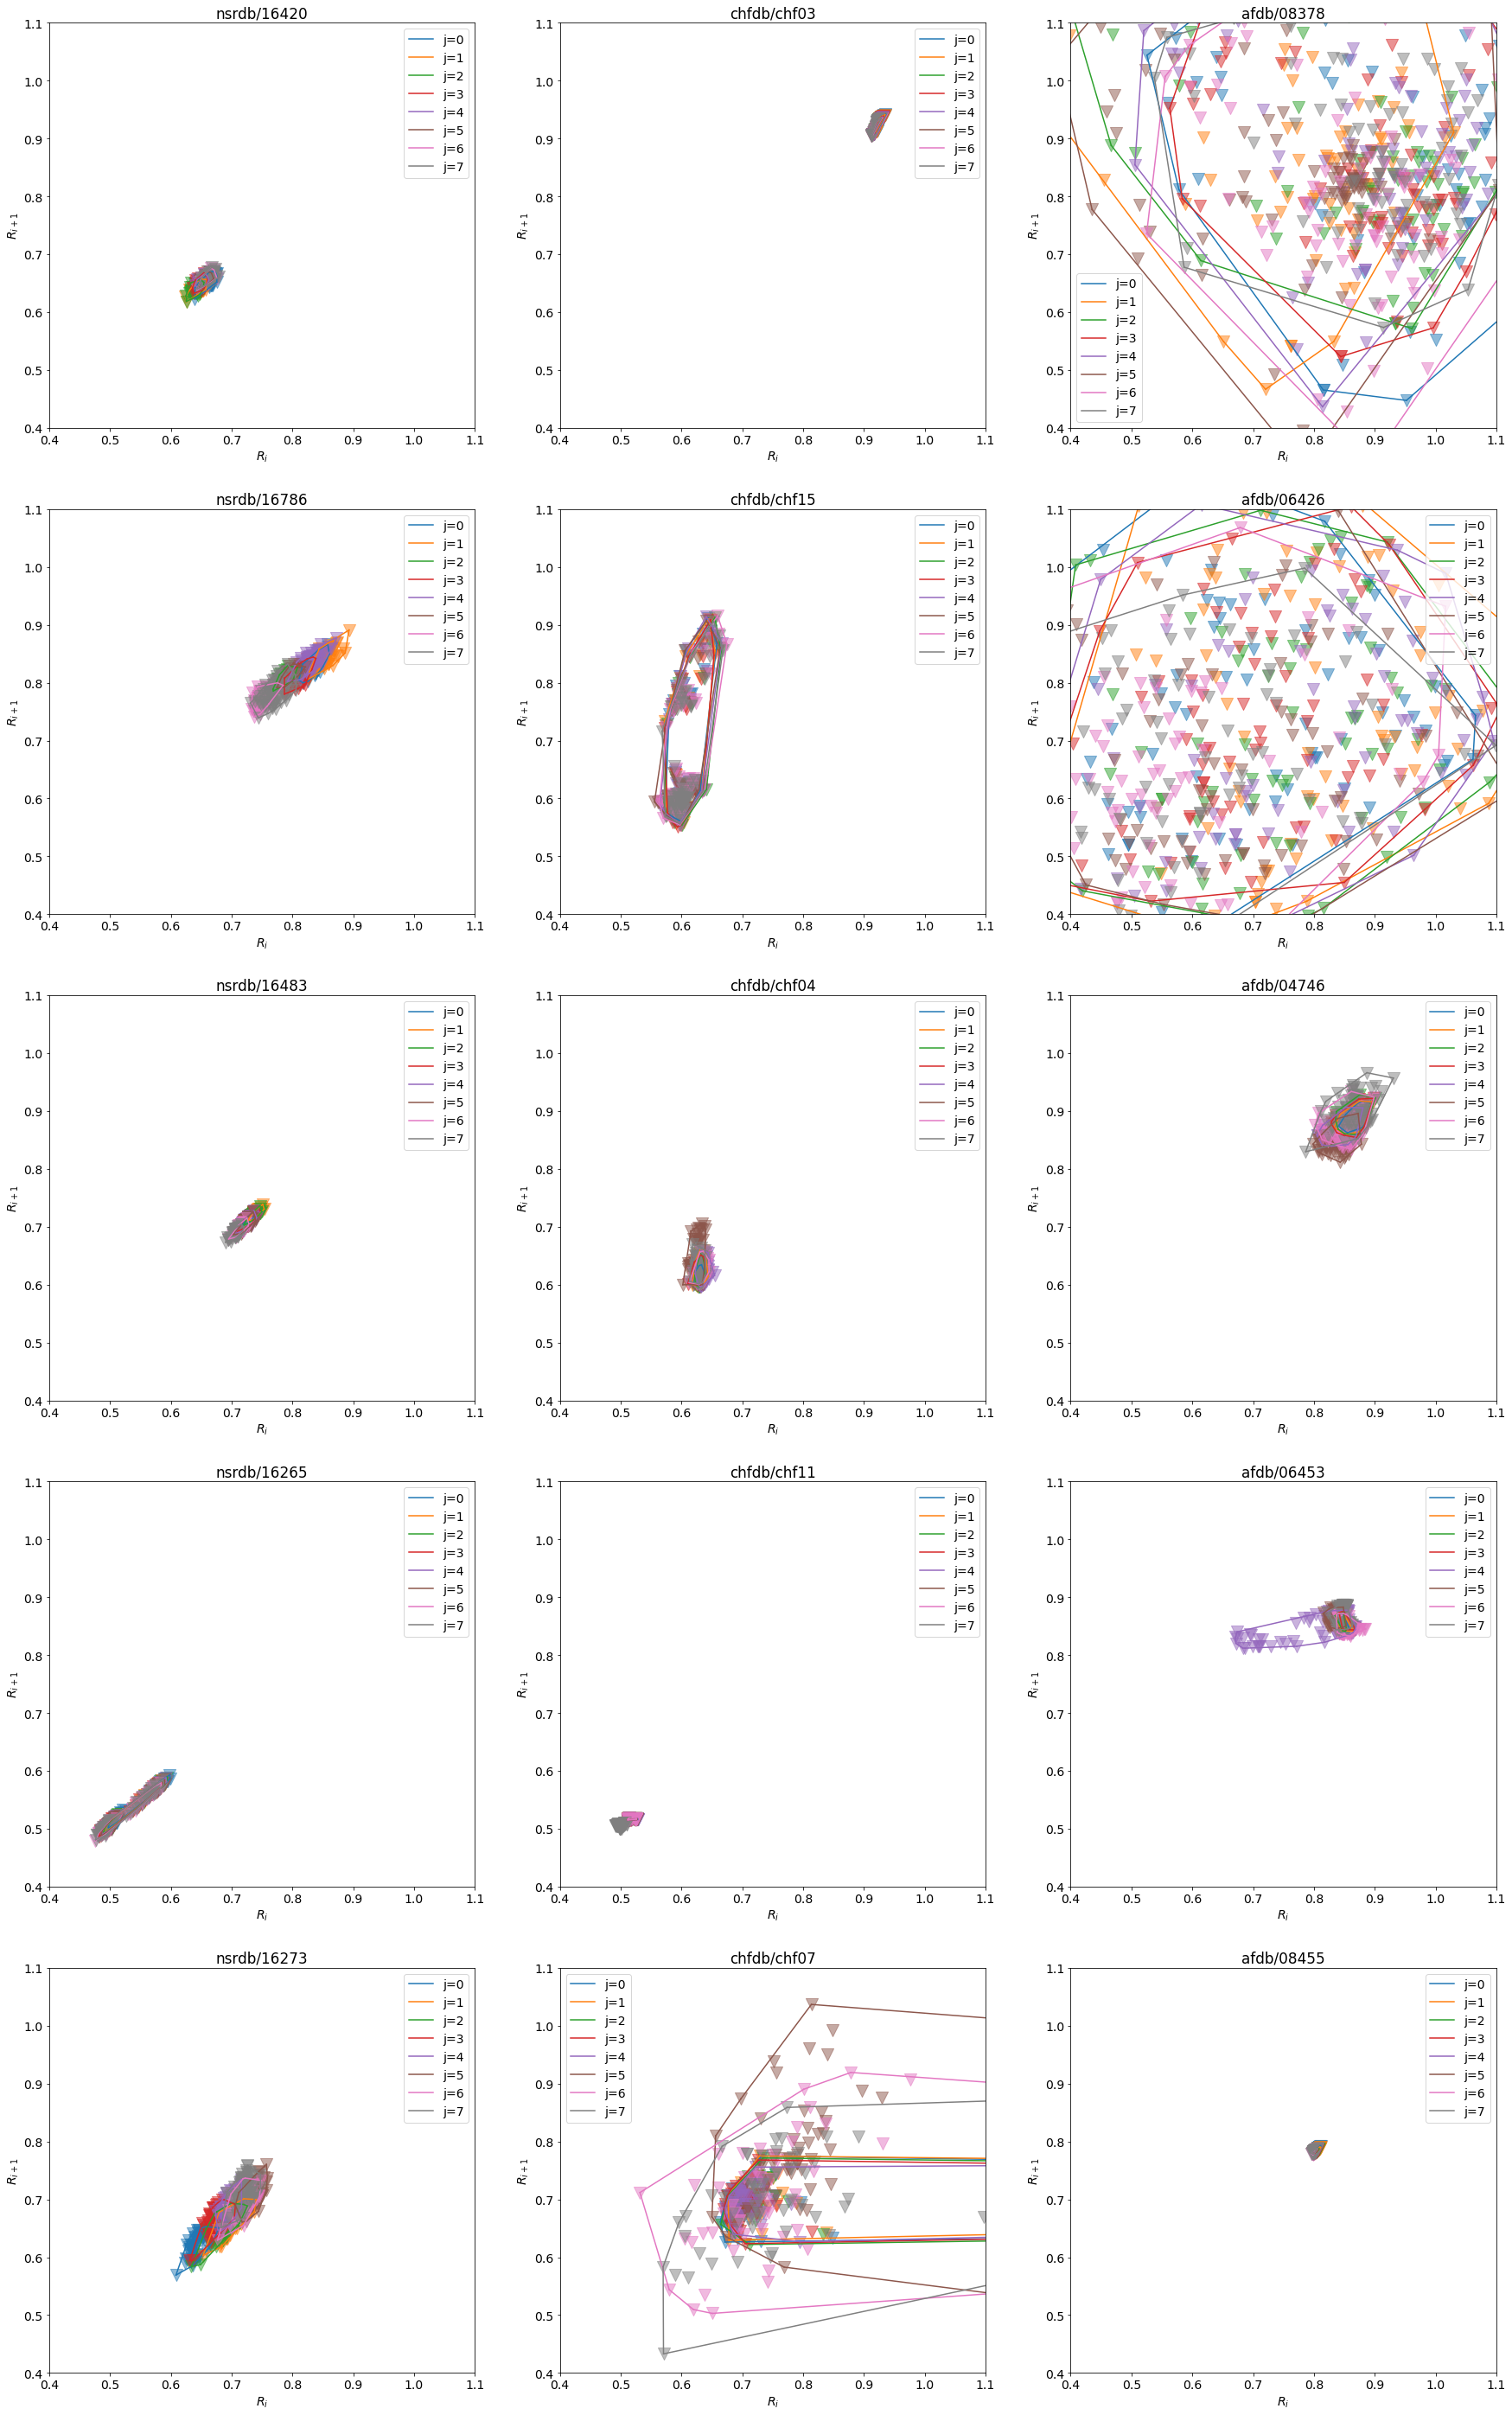

In [12]:
rec_idxs = [1, 3, 5, 7, 10,]
from_time="0:01:00"
to_time="0:06:00"

d = 2
# k = 30
xwin_sec = 10

T = 20
N_valid = 8
overlap = .9

fig_cond, ax_cond = plt.subplots(len(rec_idxs), len(DATASETS), figsize=(10*len(DATASETS), 10*len(rec_idxs)), squeeze=False)
ax_cond = np.reshape(ax_cond, (len(rec_idxs), len(DATASETS)))

for i_rec, rec_idx in enumerate(rec_idxs):
    for i_ds, ds in enumerate(DATASETS.values()):
        rec_path = ds.records[rec_idx]
        rec_name = f"{ds.name}/{rec_path.name}"
        trr, xrr = ecgrr(rec_path, ds.ann_ext, from_time=from_time, to_time=to_time)
        trr, xrr = filtrr(trr, xrr, enable_range=True, enable_moving_average=False)
        
        k = int(xwin_sec / np.mean(xrr))+1

        XY = chunk_data(xrr, window_size=d+k, overlap_size=int((d+k-1)*overlap))
        X, Y = XY[:,:k], XY[:, k:]
        X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=N_valid, shuffle=False)
        
        print(f"{rec_name} (N_train={X_train.shape[0]}, {k=})")

        vqr = VectorQuantileRegressor(n_levels=T, solver_opts={'verbose': False})
        vqr.fit(X_train, Y_train)

        vqr_samples = vqr.vector_quantiles(X_valid)
        for j in range(N_valid):
            Q1, Q2 = vqr_samples[j]

            plot_coverage_2d(
                Q1, Q2,
                alpha=0.05,
                title=rec_name,
                ax=ax_cond[i_rec, i_ds],
                xylim=[0.4, 1.1],
                xlabel="$R_i$",
                ylabel="$R_{i+1}$",
                contour_color=f"C{j}",
                contour_label=f"{j=}"
            );

## Experiment 1: Single-patient coverage over time

Goal: Monitor patient heartbeat dynamics over time though the distribution of RR intervals. Detect when there is a significant change.

Approach: fit conditional VQR models per single patient and calculate 90%-certainty contours. Then measure out-of-sample coverage on future data. When coverage drops below 90% flag as a significant change in dynamics.

### Data

- Datasets: Use standard `nsrdb`, `chfdb` and `afdb` from Physionet.
- Calculate RR intervals for each record using existing beat annotations.
- Filter RR intervals to remove noise due to gaps (beats over/under some extreme thresholds)
- Split each record into train and validation, where validation is the last `validation_proportion`% of the record.
- Split the train and validation segments into overlapping windows of length $k\cdot d_x+n\cdot d_y+\Delta$, where:
  - $k$ is the dimension of the covariates vector ($X$).
  - $n$ is the dimension of the target variable ($Y$).
  - $d_x$ and $d_y$ are the _dilation_ (gaps between points) in the covariates and data.
  - $\Delta$ is the gap between $X$ and $Y$.


### Model Training

- We'll use a vector-quantile regression (VQR) model, which estimates the (conditional) quantiles of $Y|X$.
- We'll fit a VQR model on the training set $(x^{(i)},y^{(i)})$ of **each patient** individually.
- We obtain a per-patient model.

### Conditional Coverage over time

- To measure coverage we'll use the validation set of each patient:
  - for every validation $(x^{(i)},y^{(i)})$ we calculate $\hat{Q}_{Y}(x^{(i)})$, the predicted vector quantiles of $Y|X=x^{(i)}$.
  - We calculate $C_{90}$, the 90% contour of $\hat{Q}_{Y}(x^{(i)})$.
  - We check whether $y^{(i)}$ is covered by $C_{90}$.
- We sort the coverage values of each patients temporally, to obtain a coverage curve over time.

### Experiment

- For each individual record in each dataset, iterate over the parameters $k$, $d_x$, $d_y$, $\Delta$ for $n=2$. 
- Fit the VQR model on the patient's training set.
- Measure the average coverage, $\bar{\mathcal{C}}$ on the patient's validation set.
- Measure difference between the coverage at the start and end of the validation set (e.g. last 10% - first 10%), $\Delta\mathcal{C}$.

|Dataset|Record|$k$|$\Delta$|$d_x$|$d_y$|**$\bar{\mathcal{C}}$**|**$\Delta\mathcal{C}$**|
|-------|------|---|--------|-----|-----|-----------------------|-----------------------|
|       |      |   |        |     |     |                       |                       |

- Study the relationship between the parameters producing the most coverage and the data.
- Observe whether coverage drops ($\Delta\mathcal{C}<0$).
- Plot coverage over time for the most high-delta records
- Compare between the fitted VQR model of different patients - can we cluster them based on this?

## Experiment 2: Using VQR for classification

Goal: Observe whether conditional quantiles can be used as features (which represent in a known way the underlying distribution of RR intervals) for classification into NSR, CHF, AF.


Approach: Fit a single conditional VQR model on data from all patients from all pathology types. Generate a dataset of (X,Y) pairs where X are vector quantiles from the fitted model, and Y are the pathology labels. Train a simple (possibly linear) classifier, to classify a segment of intervals into NSR, AF, CHF.


### Data

- Datasets: Use standard `nsrdb`, `chfdb` and `afdb` from Physionet.
- Split all records from all datasets into train and validation set, so that each patient is either in train or validation.
- Calculate RR intervals for each record using existing beat annotations.
- Filter RR intervals to remove noise due to gaps (beats over/under some extreme thresholds)
- Split the train and validation segments into overlapping windows of length $k\cdot d_x+n\cdot d_y+\Delta$, as before.
- Add a pathology-label to each segment: NSR/AF/CHF. This can either be taken based on the dataset, or better, based on rhythm annotations from each record.
- Possibly also add an NSR-X class representing NSR segments in the pathology datasets.

### Model Training

- We'll fit a VQR model on the training set records of **all patients** together. We obtain a single VQR model.
- We estimate vector quantiles using the fitted model on the validation set patients, and generate a new dataset (X,Y) which we call the VQR-features dataset. Here X are vector quantiles calcualted on each segment from the validation-set patients, and Y is the pathology label for that segment. We'll also split this new dataset into train and validation as usual.
- Train simple classifiers (multicalss LR, SVM, small MLP) on the VQR-features dataset.

### Experiment

- Fit the VQR model on all patient's training set.
- Iterate over the parameters $k$, $d_x$, $d_y$, $\Delta$ for $n=2$. 
- Iterate over classifier types.
- Train the classifier model.
- Study the classification performance.

|Pathology|Classifier Type|$k$|$\Delta$|$d_x$|$d_y$|Accuracy|AUC|F1|
|-------|------|---|--------|-----|-----|-----------------------|-----------------------|-|
|       |      |   |        |     |     |                       |                       ||
